# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**.

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [116]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [117]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [118]:
print(f'Data is a {data.shape} matrix')
print(f'There are {data.isna().values.sum()} NaN values in the data')
print(f'There are {data.duplicated().values.sum()} duplicate values in the data')
print(f'A short description of the data {data.info()}')
data.head()

Data is a (5391, 6) matrix
There are 0 NaN values in the data
There are 0 duplicate values in the data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB
A short description of the data None


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"


### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`.
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [119]:
data[['USD_Production_Budget', 'USD_Worldwide_Gross', 'USD_Domestic_Gross']] = data[['USD_Production_Budget', 'USD_Worldwide_Gross', 'USD_Domestic_Gross']].apply(lambda x: pd.to_numeric(x.str.replace('$','').str.replace(',','')))

**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type.

In [120]:
data['Release_Date'] = pd.to_datetime(data['Release_Date'])

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Rank                   5391 non-null   int64         
 1   Release_Date           5391 non-null   datetime64[ns]
 2   Movie_Title            5391 non-null   object        
 3   USD_Production_Budget  5391 non-null   int64         
 4   USD_Worldwide_Gross    5391 non-null   int64         
 5   USD_Domestic_Gross     5391 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 252.8+ KB


### Descriptive Statistics

**Challenge**:

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [122]:
print(f"1. Average production budget: ${data['USD_Production_Budget'].mean():,.2f}")
print(f"2. Average movie worldwide gross revenue: ${data['USD_Worldwide_Gross'].mean():,.2f}")
print(f"3. Minimum gross revenue worldwide: ${data['USD_Worldwide_Gross'].min():,.2f}, and domestic: ${data['USD_Domestic_Gross'].min():,.2f}")
print(f"4. 25% of films make: ${data['USD_Worldwide_Gross'].quantile(0.25):,.2f}, while their budget is: ${data['USD_Production_Budget'].quantile(0.25):,}")
print(f"5. The most expensive film to make cost: ${data.USD_Production_Budget.max():,}, and the most money a film ever made worldwide was: ${data.USD_Worldwide_Gross.max():,}")
print(f"6. Lowest budget film made: ${data.USD_Worldwide_Gross[data.USD_Production_Budget.idxmin()]:,} while the highest budget film made: ${data.USD_Worldwide_Gross[data.USD_Production_Budget.idxmax()]:,}")

1. Average production budget: $31,113,737.58
2. Average movie worldwide gross revenue: $88,855,421.96
3. Minimum gross revenue worldwide: $0.00, and domestic: $0.00
4. 25% of films make: $3,865,206.00, while their budget is: $5,000,000.0
5. The most expensive film to make cost: $425,000,000, and the most money a film ever made worldwide was: $2,783,918,982
6. Lowest budget film made: $181,041 while the highest budget film made: $2,783,918,982


In [123]:
data['USD_Domestic_Gross'].describe()
print(f"{data['USD_Production_Budget'].quantile(0.25):,}")

5,000,000.0


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [124]:
print(f"There were {(data.USD_Domestic_Gross == 0).sum()} who grossed $0 in the United States")
print(f"The top 5 most expensive movies to make that grossed nothing in the US were:\n{data[data.USD_Domestic_Gross == 0].nlargest(5, 'USD_Production_Budget').Movie_Title.to_string(index=False)}")

There were 512 who grossed $0 in the United States
The top 5 most expensive movies to make that grossed nothing in the US were:
                       Singularity
                           Aquaman
                 A Wrinkle in Time
                    Amusement Park
Don Gato, el inicio de la pandilla


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [125]:
print(f"There were {(data.USD_Worldwide_Gross == 0).sum()} who grossed $0 in the United States")
print(f"The top 5 most expensive movies to make that grossed nothing worldwide were:\n{data[data.USD_Worldwide_Gross == 0].nlargest(5, 'USD_Production_Budget').Movie_Title.to_string(index=False)}")

There were 357 who grossed $0 in the United States
The top 5 most expensive movies to make that grossed nothing worldwide were:
      Singularity
          Aquaman
A Wrinkle in Time
   Amusement Park
 The Ridiculous 6


### Filtering on Multiple Conditions

In [126]:
data.query('USD_Worldwide_Gross > 0 and USD_Domestic_Gross == 0')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States.

Hint: This time you'll have to use the `and` keyword.

In [127]:
data.loc[(data.USD_Domestic_Gross == 0) & (data.USD_Worldwide_Gross > 0)]

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office?
* Create another DataFrame called data_clean that does not include these films.

In [128]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')

In [129]:
data_clean = data[data.Release_Date < scrape_date]
data_clean.nlargest(10, 'Release_Date')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5383,2521,2017-12-31,The Thousand Miles,20000000,0,0
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812
5377,489,2017-10-02,The Lego Batman Movie,80000000,310940997,175750384
5378,914,2017-10-02,Fifty Shades Darker,55000000,376856949,114434010
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184
5375,57,2017-09-06,The Mummy,195000000,397644453,79741080
5376,4004,2017-09-06,It Comes at Night,5000000,17250101,13845101
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Films that Lost Money

**Challenge**:
What is the percentage of films where the production costs exceeded the worldwide gross revenue?

In [130]:
print(f"{data_clean.query('USD_Production_Budget > USD_Worldwide_Gross').shape[0]/data_clean.shape[0]*100:.2f}%")

37.28%


# Seaborn for Data Viz: Bubble Charts

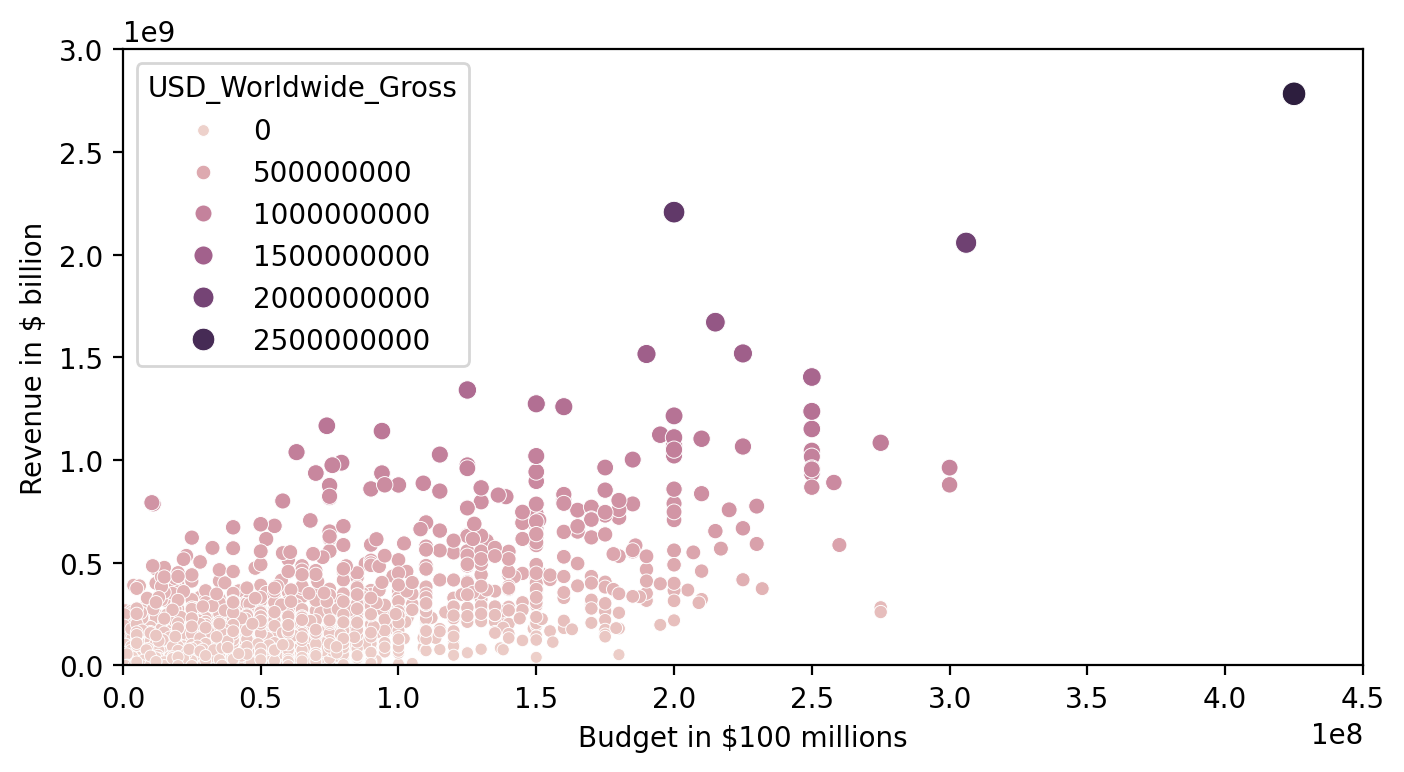

In [131]:
plt.figure(figsize=(8,4), dpi=200)

ax = sns.scatterplot(data=data_clean,
                x='USD_Production_Budget',
                y='USD_Worldwide_Gross',
                hue='USD_Worldwide_Gross',
                size='USD_Worldwide_Gross')

ax.set(ylim=(0, 3e9),
       xlim=(0, 4.5e8),
       ylabel='Revenue in $ billion',
       xlabel='Budget in $100 millions',
       )

plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



In [132]:
data_clean

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000
...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343


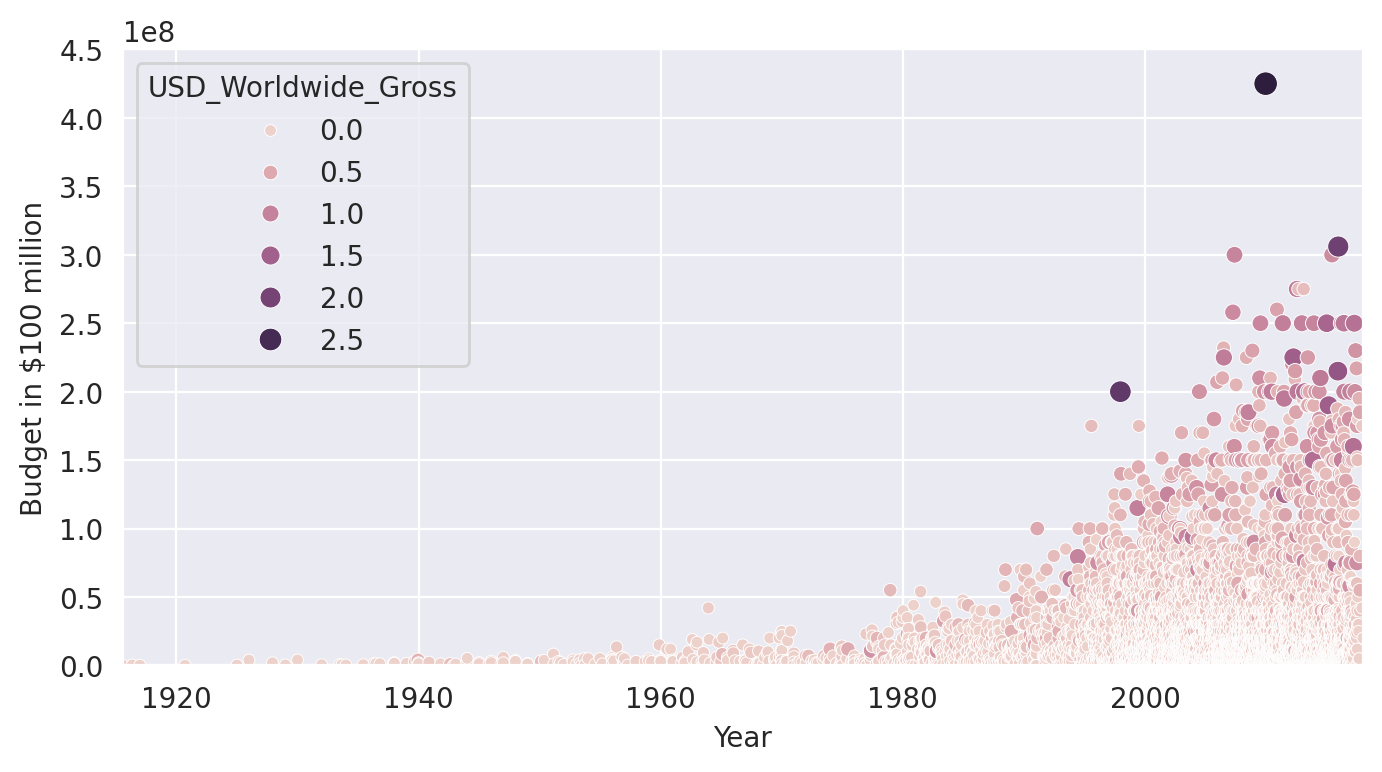

In [133]:
plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style('darkgrid'):
    ax = sns.scatterplot(data=data_clean,
                    x='Release_Date',
                    y=data_clean['USD_Production_Budget'],
                    hue=data_clean['USD_Worldwide_Gross']/1e9,
                    size=data_clean['USD_Worldwide_Gross']/1e9)

    ax.set(xlim=(data_clean.Release_Date.min(), data_clean.Release_Date.max()),
        ylim=(0.0, 4.5e8),
        ylabel='Budget in $100 million',
        xlabel='Year',)

plt.show()

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release.

<img src=https://i.imgur.com/0VEfagw.png width=650>

Here's how:
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column.
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [134]:
data_clean['Decade'] = pd.DatetimeIndex(data_clean.Release_Date).year//10*10
data_clean

<ipython-input-134-8a7de0fb3d35>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Decade'] = pd.DatetimeIndex(data_clean.Release_Date).year//10*10


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000,1910
1,5140,1916-05-09,Intolerance,385907,0,0,1910
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000,1910
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000,1920
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000,1920
...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184,2010
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812,2010
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,2010
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343,2010


### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [135]:
old_films = data_clean.query('Decade < 1970')
new_films = data_clean.query('Decade >= 1970')

# Seaborn Regression Plots

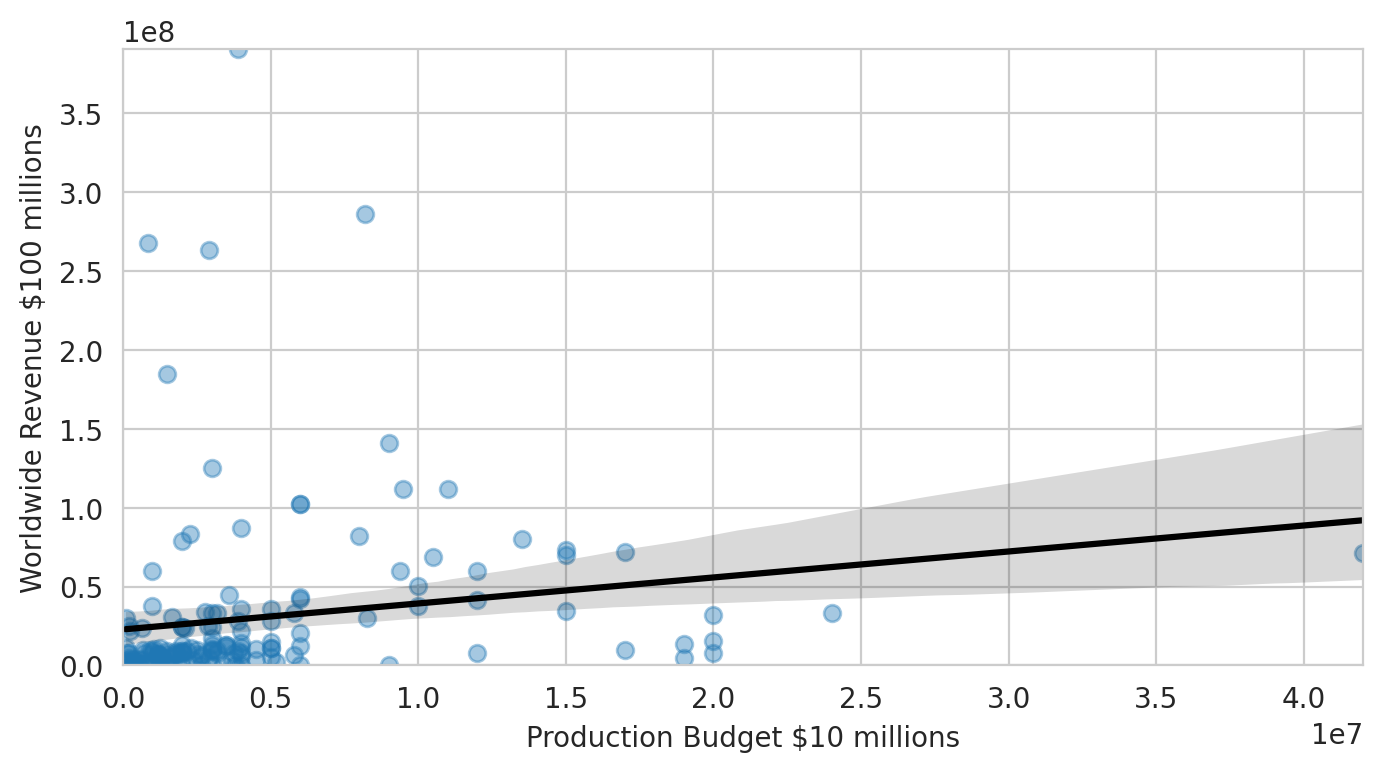

In [136]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('whitegrid'):
    ax = sns.regplot(
        old_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        scatter_kws = {'alpha': 0.4},
        line_kws = {'color':'black'},
        )

    ax.set(
        xlim=(0, old_films.USD_Production_Budget.max()),
        ylim=(0, old_films.USD_Worldwide_Gross.max()),
        xlabel='Production Budget $10 millions',
        ylabel='Worldwide Revenue $100 millions'
    )

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`.
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

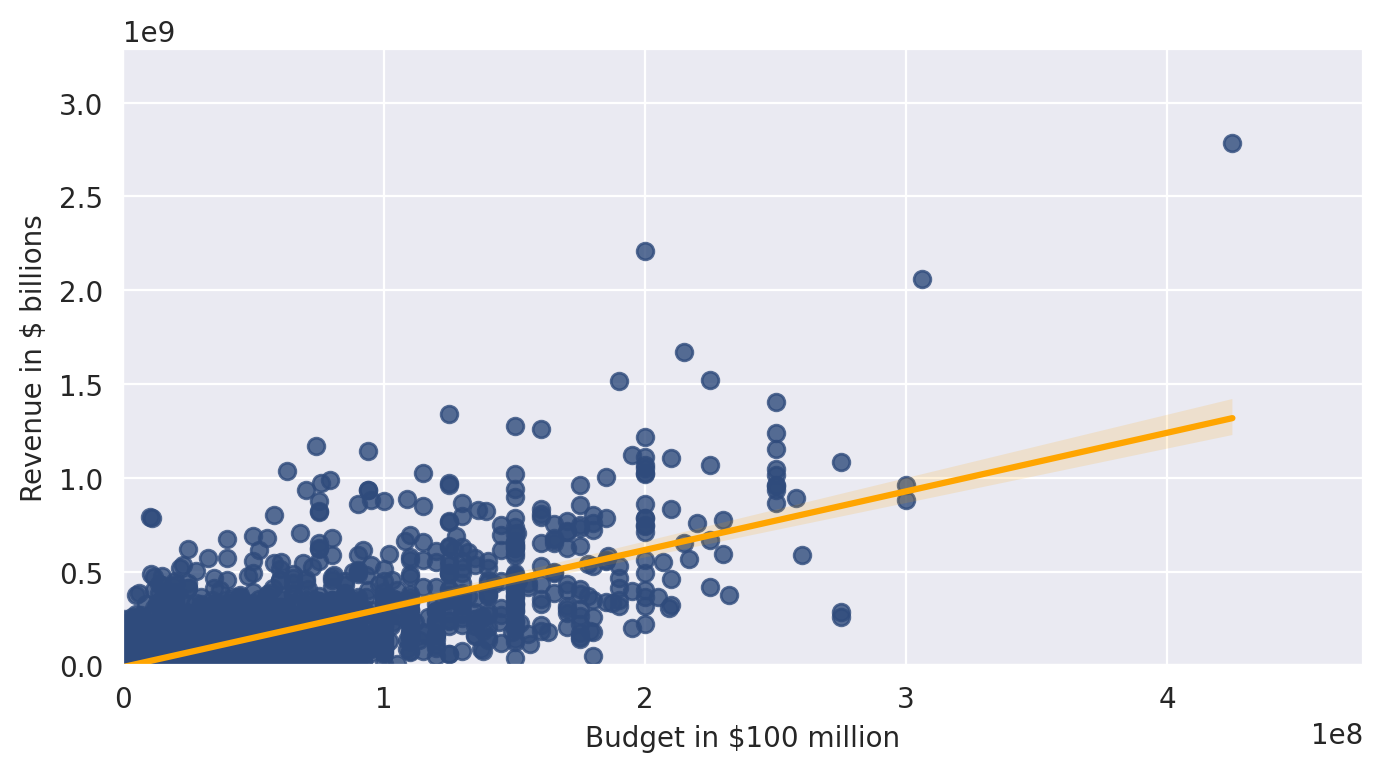

In [137]:
plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style('darkgrid'):
    ax = sns.regplot(
        new_films,
        x='USD_Production_Budget',
        y='USD_Worldwide_Gross',
        scatter_kws = {'color': '#2f4b7c'},
        line_kws = {'color': 'orange'},
        )

    ax.set(
        xlim=(0.0, new_films.USD_Production_Budget.max()+0.5e8),
        ylim=(0.0, new_films.USD_Worldwide_Gross.max()+0.5e9),
        xlabel='Budget in $100 million',
        ylabel='Revenue in $ billions',
        )

plt.show()

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [151]:
regression = LinearRegression()
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])
regression.fit(X, y)
print(regression.intercept_)
print(regression.coef_)
print(f"{regression.score(X, y):.3f}")

[-8650768.00661027]
[[3.12259592]]
0.558


**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [152]:
regression = LinearRegression()
X = pd.DataFrame(old_films, columns=['USD_Production_Budget'])
y = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

In [153]:
regression.fit(X, y)
print(regression.intercept_)
print(regression.coef_)
print(f"{regression.score(X, y):.3f}")

[22821538.63508039]
[[1.64771314]]
0.029


# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million?

In [159]:
print(f"{round((regression.intercept_ + regression.coef_*350e6)[0][0])}")

599521139
